In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pingouin as pg
import matplotlib.pyplot as plt
from datetime import timedelta
from datetime import datetime
from scipy import special
from scipy import stats
sns.set(rc={'figure.figsize' : (12, 5)}, font='verdana')
plt.style.use('dark_background')

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока)

In [2]:
url='https://drive.google.com/file/d/18Fa0cDVGq7bf8O7KEb23CFgU0w5qsMaD/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df_r = pd.read_csv(url, sep=";")
df_r

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5
...,...,...
999995,1600874034,1110618
999996,1600874086,1110619
999997,1600874139,1110620
999998,1600874191,1110621


In [3]:
url='https://drive.usercontent.google.com/download?id=12xLu8LW-RvixxIPkourv73x4IUbqpYow&export=download&authuser=0&confirm=t&uuid=d43e5d1c-cec3-4518-84ae-d49b30d9c527&at=AENtkXYRTcBqWPAkd3eLSmLq1DSN%3A1733307676786'
df_a = pd.read_csv(url, sep=";")
df_a

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2
...,...,...
9601008,1600874034,1110618
9601009,1600874086,1110619
9601010,1600874139,1110620
9601011,1600874191,1110621


In [4]:
#Таймстэмпы оказались импортированы как целые числа, переведем их даты и переименуем колонки в привычные, простые и запоминающиеся

df_r.reg_ts = pd.to_datetime(df_r.reg_ts, unit='s')
df_r = df_r.rename(columns = {'reg_ts' : 'r_date',
                     'uid' : 'id'})
df_a.auth_ts = pd.to_datetime(df_a.auth_ts, unit='s')
df_a = df_a.rename(columns = {'auth_ts' : 'a_date',
                     'uid' : 'id'})

In [5]:
df_r.id.nunique() == len (df_r)

True

В регистрациях у нас только уникальные id

In [6]:
print(f' в авторизациях у нас {df_a.id.nunique()} уникальных id в {len(df_a)} авторизациях')

 в авторизациях у нас 1000000 уникальных id в 9601013 авторизациях


Все зарегистрированные id авторизовались хотя бы 1 раз

Соберем два набора данных в один по id, пао сути просто допишем в каждую авторизацию дату регистрации этого id.

In [8]:
df = pd.merge(df_a, df_r, how = 'left', on='id')
df.head(3)

,a_date,id,r_date
0,1998-11-18 09:43:43,1,1998-11-18 09:43:43
1,1999-07-22 22:38:09,2,1999-07-22 22:38:09
2,1999-07-25 16:46:46,2,1999-07-22 22:38:09


Посмотрим на данные

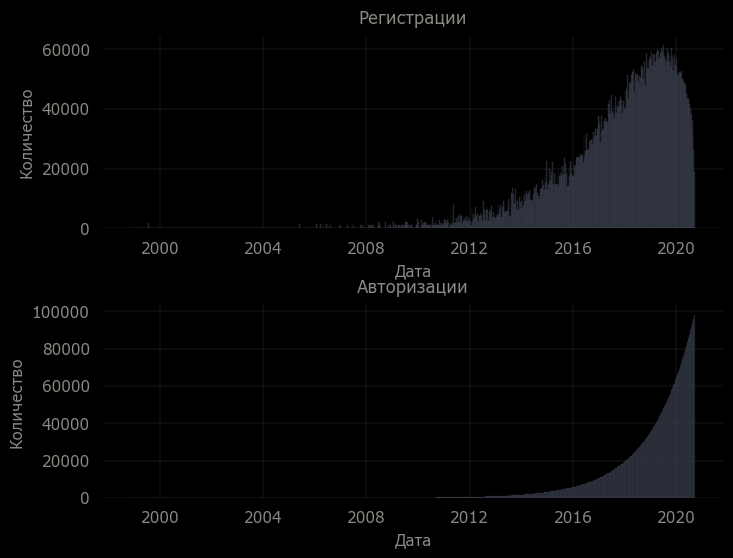

In [56]:
plt.figure(figsize=(8,6))
plt.subplots_adjust(wspace= 0.2, 
                    hspace= 0.4)
plt.subplot(2, 1, 1)
sns.histplot(df.r_date, color='#171e2f')
plt.title('Регистрации', fontsize=12, y=1.02, color='#8b8a84')
plt.xlabel("Дата", labelpad = 5, fontsize= 11,color='#8b8a84')
plt.ylabel("Количество", labelpad = 5, fontsize= 11,color='#8b8a84')
plt.tick_params(axis='both', colors='#8b8a84')
for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1) 

plt.subplot(2, 1, 2)
sns.histplot(df.a_date, color='#171e2f')
plt.tick_params(axis='both', colors='#8b8a84')
plt.title('Авторизации', fontsize=12, y=1.02,color='#8b8a84')
plt.xlabel("Дата", labelpad = 5, fontsize= 11,color='#8b8a84')
plt.ylabel("Количество", labelpad = 5, fontsize= 11,color='#8b8a84')
for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1)

plt.show()

In [9]:
df_tmp=df.groupby('id').a_date.count().sort_values(ascending = False)
print(f'\
1. Временной интервал набора данных:    начало:  {df['r_date'].min()} \n\
                                        конец:   {df['r_date'].max()} \n\
2. Уникальных пользователей:                     {df_r.id.nunique()} \n\
3. Зарегистрировались, но в игру так и не зашли: {pd.merge(df_r, df_a, how='left', on='id').a_date.isna().sum()}\n\
4. Зашли в игру один раз                         {df_tmp[df_tmp.values == 1].count()} пользователей  ({round(100*df_tmp[df_tmp.values == 1].count()/len(df_r), 1)}%) \n\
5. Зашли в игру больше одного раза:              {df_tmp[df_tmp.values > 1].count()} пользователей  ({round(100*df_tmp[df_tmp.values > 1].count()/len(df_r), 1)}%) \n\
6. NaN в наборе данных                           {df.isna().a_date.sum()+df.isna().r_date.sum()+df.isna().id.sum()} \n\
')


1. Временной интервал набора данных:    начало:  1998-11-18 09:43:43 
                                        конец:   2020-09-23 15:17:24 
2. Уникальных пользователей:                     1000000 
3. Зарегистрировались, но в игру так и не зашли: 0
4. Зашли в игру один раз                         761622 пользователей  (76.2%) 
5. Зашли в игру больше одного раза:              238378 пользователей  (23.8%) 
6. NaN в наборе данных                           0 



Retention игроков "по дням от даты регистрации игрока" - нас интресует возврат игроков, зарегистрировавшихся в определенный день, в игру в течение определенного временного интервала в днях. Значит в функции будет два аргумента: 

- День регистрации - reg_day

- Число дней на возврат в игру - days_to_get_back

и еще можно добавить источник данных в качестве аргумента, поскольку для разных целей можно предварительно готовить его различными способами

In [61]:
def rtn(reg_day, days_to_be_back, df_rgd):
    
    # Готовим дату если нужно - зависит от способа дальнейшего использования функции
    # reg_day = datetime.strptime(reg_day, '%Y-%m-%d')

    #Вырезаем нужный интервал из источника данных, чтобы не крутить лишний объем данных
    df_tmp = df_rgd[(df_rgd.r_date >= reg_day) & (df_rgd.r_date <= reg_day + timedelta(days = days_to_be_back))].copy()

    # Собираем пользователей, зарегистрировавшихся в указанный день
    df_tmp.r_date = df_tmp.r_date.dt.date
    df_tmp.r_date = pd.to_datetime(df_tmp.r_date)
    rgd_users     = df_tmp[df_tmp.r_date == np.datetime64(reg_day.date())]\
                          .groupby('id',as_index = False)\
                          .agg({'r_date':'nunique'})\
                          .id
    coh_cnt       = rgd_users.count()

    # Считаем последний день диапазона для возврата
    last_day      = reg_day + timedelta(days = days_to_be_back)

    # Считаем активных пользователей за период из числа зарегистрировавшихся в указанный день
    df_active     = df_tmp[(df_tmp.a_date > reg_day) & (df_tmp.a_date <= last_day) & (df_tmp.id.isin(rgd_users))]\
                          .groupby('id', as_index = False)\
                          .agg({'r_date':'count'})
    active_users  = df_active[df_active.r_date > 1].r_date.count()
    return [reg_day.date(), days_to_be_back, round(active_users / coh_cnt, 3)]

Теперь у нас есть функция, на вход котрой подаются дата регистрации, временной интервал в днях и датафрейм - источник данных. Функция считает, какое количество пользователей, зарегистрировавшихся в указанную дату - заходили повторно за указанный промежуток времени.

Эту функцию можно использовать как для одиночного вычисления, так и для сбора данных по конкретным датам. Например, так

In [62]:
# АХТУНГ - 5 минут считается на моем компе

t = pd.DataFrame({'reg_date': [1], 'retention' : [3]})
for i in range(1,3676):
    r = pd.Series(rtn(datetime.strptime('2010-09-01', '%Y-%m-%d') + timedelta(days = i), 10, df))
    r1 = pd.DataFrame({'reg_date': [r[0]], 'retention' : [r[2]]})
    t = pd.concat([t, r1], axis = 0 ).reset_index(drop = True)
t = t.drop(index = 0, axis = 1)
t.reg_date = pd.to_datetime(t.reg_date)

За 10 лет для каждой дневной когорты мы посчитали десятидневный retention и собрали в массив. Теперь можно посмотреть на график.

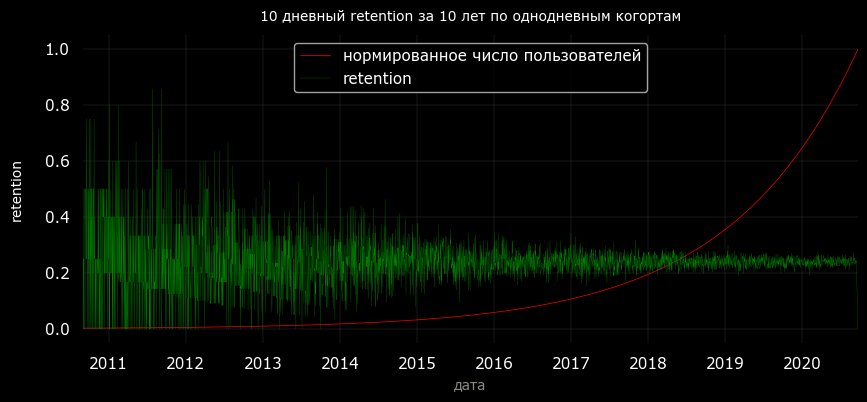

In [63]:
df_cnt = df.groupby('id').r_date.min().to_frame().reset_index()
plt.figure(figsize=(10,4))
sns.lineplot(x = df_cnt.r_date, y = df_cnt.index/1000000, linewidth=0.5, color='red', label='нормированное число пользователей')
sns.lineplot(x = t.reg_date, y = t.retention, linewidth=0.2, color='green', label='retention')
plt.title('10 дневный retention за 10 лет по однодневным когортам', fontsize=10, y=1.02)
plt.xlim(datetime.strptime('2010-09-01', '%Y-%m-%d'), datetime.strptime('2020-09-23', '%Y-%m-%d'))
plt.xlabel("дата", labelpad = 5, fontsize= 10,color='#8b8a84')
plt.ylabel('retention', labelpad = 15, fontsize= 10)
for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1) 
plt.show()

Видим, что на начальных этапах пользователями являлся узкий круг разработчиков, тестировщиков, энтузиастов сообщество раширялось скачкообразно по мере нововедений, которые сразу же проверялись - и ретеншн подскакивал почти до 100%. Но по мере роста числа обычных польхователей начало проявлятся истинное распределение и его среднее.

С помощью функции мы можем посмотреть не только историю определенного retention дневных когорт, но и распределение retention разной периодичности для определенных когорт.

In [64]:
tt = pd.DataFrame({'reg date': [1], 'days_shift' : [2], 'retention' : [3]})
for i in range(30):
    rr = pd.Series(rtn(datetime.strptime('2018-04-09', '%Y-%m-%d'), 1+i, df))
    rr1 = pd.DataFrame({'reg date': [rr[0]], 'days_shift' : [rr[1]], 'retention' : [rr[2]]})
    tt = pd.concat([tt, rr1], axis = 0 ).reset_index(drop = True)
tt = tt.drop(index = 0, axis = 1)

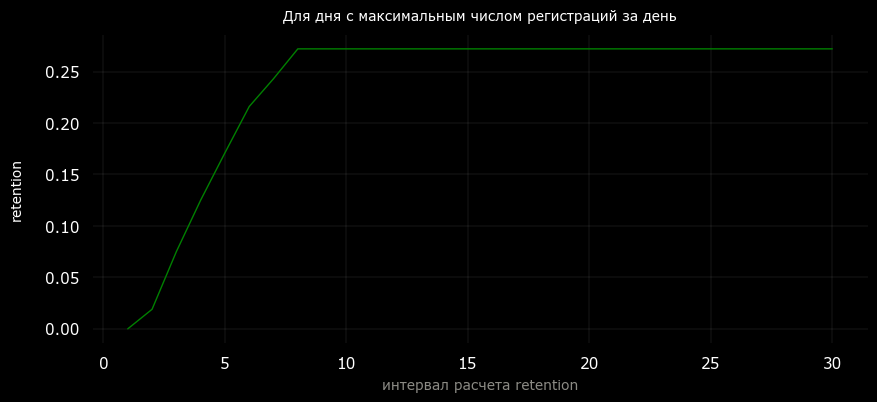

In [65]:
plt.figure(figsize=(10,4))
sns.lineplot(x = tt.days_shift, y = tt.retention, linewidth=1, color='green')
plt.title('Для дня с максимальным числом регистраций за день', fontsize=10, y=1.02)
plt.xlabel("интервал расчета retention", labelpad = 5, fontsize= 10,color='#8b8a84')
plt.ylabel('retention', labelpad = 15, fontsize= 10)
for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1) 
plt.show()

Как-будто, если пользователь не зашел повторно за 10 дней - то он скорее всего уже не зайдет никогда

In [66]:
days_to_get_back = df[df.r_date != df.a_date].groupby('id', as_index = False).agg({'a_date':'min'})
df_back = pd.merge(df_r, days_to_get_back, how = 'left', on='id')
df_back['days'] = (df_back.a_date - df_back.r_date).dt.floor('D')
df_back.days.value_counts(dropna=False)

days
NaT       761622
1 days     40202
2 days     39955
3 days     39732
4 days     39605
6 days     39577
5 days     39306
7 days         1
Name: count, dtype: int64

Получается, если пользователь не заходил в игру повторно в течение 8 дней, то больше он в игру не заходил никогда